<a href="https://colab.research.google.com/github/ChiriKamau/limaAI/blob/main/notebooks/Check_perfomance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🍅 Tomato Model Performance Evaluation

**Welcome to the Model Evaluation Notebook!**

This notebook evaluates two CNN models and two MobileNetV2 transfer learning models for tomato disease classification, stored in `.keras` format on Google Drive. The models target:

- **Ripe Model**: 3 classes (*Blossom End Rot* ('R_ber'), *Bacterial Spots* ('R_spots'), *Healthy* ('R_healthy'))
- **Green Model**: 4 classes (*Blossom End Rot* ('G_ber'), *Bacterial Spots* ('G_spots'), *Late Blight* ('G_lateblight'), *Healthy* ('G_healthy'))

**Goal**: Assess performance using accuracy, precision, recall, F1-score, and confusion matrices, focusing on minority classes (e.g., 'G_lateblight') due to dataset imbalance. Confusion matrix heatmaps visualize class-specific performance to compare CNN and transfer learning models.

**Steps**: Load validation data, load models, compute metrics, visualize results, and summarize model performance.

### Import Libraries and Set Up Validation Data

This cell imports libraries for model evaluation, visualization, and data loading from Google Drive. It mounts Google Drive to access the tomato dataset and defines validation data generators for ripe and green splits.

The generators load images (224x224, batch size 16) from the validation directories without augmentation, ensuring consistent evaluation. Class indices are printed to confirm the dataset structure (3 classes for ripe, 4 for green).

In [17]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
output_dir = '/content/drive/MyDrive/Tomato_dataset/cnn_crops'
ripe_val_dir = os.path.join(output_dir, 'ripe/val')
green_val_dir = os.path.join(output_dir, 'green/val')

# Validation generators for CNN models (224x224)
cnn_val_datagen = ImageDataGenerator(rescale=1./255)
ripe_cnn_val_gen = cnn_val_datagen.flow_from_directory(
    ripe_val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)
green_cnn_val_gen = cnn_val_datagen.flow_from_directory(
    green_val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Validation generators for transfer learning models (160x160)
transfer_val_datagen = ImageDataGenerator(rescale=1./255)
ripe_transfer_val_gen = transfer_val_datagen.flow_from_directory(
    ripe_val_dir,
    target_size=(160, 160),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)
green_transfer_val_gen = transfer_val_datagen.flow_from_directory(
    green_val_dir,
    target_size=(160, 160),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Print class indices
print("Ripe CNN validation classes:", ripe_cnn_val_gen.class_indices)
print("Green CNN validation classes:", green_cnn_val_gen.class_indices)
print("Ripe MobileNetV2 validation classes:", ripe_transfer_val_gen.class_indices)
print("Green MobileNetV2 validation classes:", green_transfer_val_gen.class_indices)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 384 images belonging to 3 classes.
Found 946 images belonging to 4 classes.
Found 384 images belonging to 3 classes.
Found 946 images belonging to 4 classes.
Ripe CNN validation classes: {'R_ber': 0, 'R_healthy': 1, 'R_spots': 2}
Green CNN validation classes: {'G_ber': 0, 'G_healthy': 1, 'G_lateblight': 2, 'G_spots': 3}
Ripe MobileNetV2 validation classes: {'R_ber': 0, 'R_healthy': 1, 'R_spots': 2}
Green MobileNetV2 validation classes: {'G_ber': 0, 'G_healthy': 1, 'G_lateblight': 2, 'G_spots': 3}


### Load Trained Models

This cell loads the trained CNN and MobileNetV2 models from `.keras` files stored in Google Drive. It includes two CNN models (for ripe and green tomatoes) and two transfer learning models (MobileNetV2) for comparison.

The models are loaded using `tf.keras.models.load_model`, ensuring they’re ready for evaluation on the validation sets. Paths match those used during training for consistency.

In [18]:
# Model paths
ripe_cnn_path = '/content/drive/MyDrive/Tomato_dataset/models/ripe_cnn(v2).keras'
green_cnn_path = '/content/drive/MyDrive/Tomato_dataset/models/green_cnn(v2).keras'
ripe_transfer_path = '/content/drive/MyDrive/Tomato_dataset/models/ripe_mobilenet(v2).keras'
green_transfer_path = '/content/drive/MyDrive/Tomato_dataset/models/green_mobilenet(v3)/green_mobilenet(v3.5).keras'

# Load models
ripe_cnn_model = tf.keras.models.load_model(ripe_cnn_path)
green_cnn_model = tf.keras.models.load_model(green_cnn_path)
ripe_transfer_model = tf.keras.models.load_model(ripe_transfer_path)
green_transfer_model = tf.keras.models.load_model(green_transfer_path)

print("All models loaded successfully.")

ValueError: File not found: filepath=/content/drive/MyDrive/Tomato_dataset/models/green_mobilenet(v3)/green_mobilenet(v3.5).keras. Please ensure the file is an accessible `.keras` zip file.

### Evaluate Model Performance

This cell evaluates each model on its respective validation set, computing accuracy, precision, recall, and F1-score per class. It collects true labels and predictions from the validation generators, ensuring `shuffle=False` for alignment.

The `classification_report` from scikit-learn provides detailed metrics, emphasizing minority classes (e.g., 'R_spots', 'G_lateblight'). Results are printed for both CNN and transfer learning models to compare performance.

In [13]:
# Function to evaluate a model
def evaluate_model(model, val_gen, model_name):
    val_gen.reset()  # Reset generator
    y_true = val_gen.classes
    y_pred = model.predict(val_gen, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred_classes, target_names=val_gen.class_indices.keys()))

    return y_true, y_pred_classes

# Evaluate models
ripe_cnn_true, ripe_cnn_pred = evaluate_model(ripe_cnn_model, ripe_cnn_val_gen, "Ripe CNN")
green_cnn_true, green_cnn_pred = evaluate_model(green_cnn_model, green_cnn_val_gen, "Green CNN")
ripe_transfer_true, ripe_transfer_pred = evaluate_model(ripe_transfer_model, ripe_transfer_val_gen, "Ripe MobileNetV2")
green_transfer_true, green_transfer_pred = evaluate_model(green_transfer_model, green_transfer_val_gen, "Green MobileNetV2")

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 349ms/step

Classification Report for Ripe CNN:
              precision    recall  f1-score   support

       R_ber       0.67      0.45      0.54        80
   R_healthy       0.65      0.66      0.66       194
     R_spots       0.39      0.46      0.42       110

    accuracy                           0.56       384
   macro avg       0.57      0.53      0.54       384
weighted avg       0.58      0.56      0.57       384

60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 338ms/step

Classification Report for Green CNN:
              precision    recall  f1-score   support

       G_ber       0.40      0.20      0.26        41
   G_healthy       0.58      0.79      0.67       481
G_lateblight       0.25      0.61      0.35        41
     G_spots       0.50      0.22      0.31       383

    accuracy                           0.53       946
   macro avg       0.43      0.45      0.40       946
weighted avg       0.53      0.53      0.49       946

24/24 ━━━━━━━━━━━━━━━━━━━━

### Visualize Confusion Matrices

This cell creates confusion matrix heatmaps for each model to visualize classification performance. Using `confusion_matrix` from scikit-learn, it compares true vs. predicted labels for the validation sets.

Heatmaps are plotted with `seaborn` for ripe (3 classes) and green (4 classes) models, highlighting misclassifications, especially for minority classes like 'G_lateblight'. These visuals help compare CNN and transfer learning models.

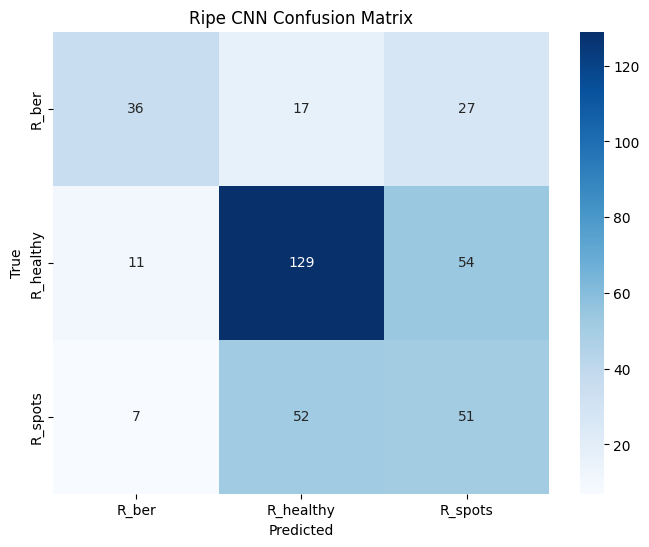

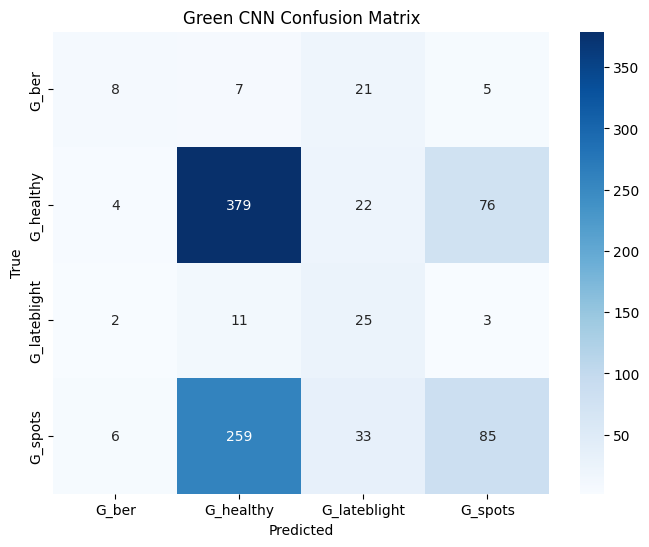

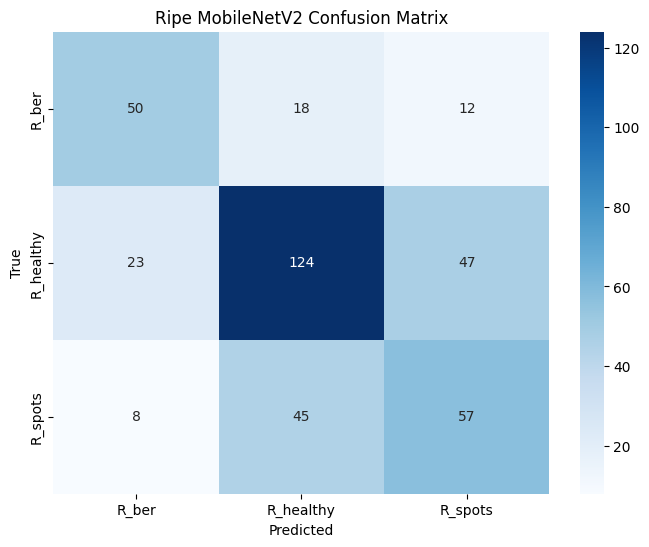

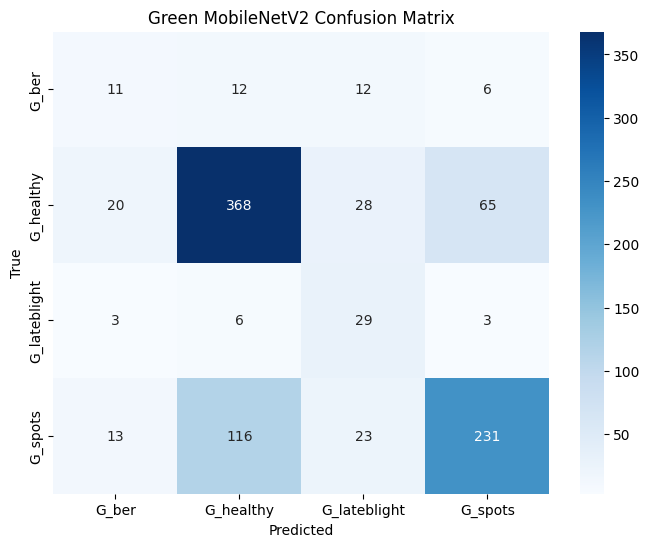

In [14]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(ripe_cnn_true, ripe_cnn_pred, list(ripe_cnn_val_gen.class_indices.keys()), "Ripe CNN Confusion Matrix")
plot_confusion_matrix(green_cnn_true, green_cnn_pred, list(green_cnn_val_gen.class_indices.keys()), "Green CNN Confusion Matrix")
plot_confusion_matrix(ripe_transfer_true, ripe_transfer_pred, list(ripe_transfer_val_gen.class_indices.keys()), "Ripe MobileNetV2 Confusion Matrix")
plot_confusion_matrix(green_transfer_true, green_transfer_pred, list(green_transfer_val_gen.class_indices.keys()), "Green MobileNetV2 Confusion Matrix")

### Compare Model Performance

This cell summarizes the performance of CNN and MobileNetV2 models. It compares macro-averaged F1-scores from the classification reports to assess overall performance, with a focus on minority classes (e.g., 'R_spots', 'G_lateblight').

Key observations include which model better handles imbalanced classes and whether transfer learning outperforms the custom CNN. Results guide model selection for deployment or further tuning.

In [ ]:
# Manual comparison based on classification reports
print("\nModel Comparison Summary:")
print("1. Ripe Models:")
print("- CNN: Check F1-scores for 'R_spots' (minority class) in classification report.")
print("- MobileNetV2: Likely better for minority classes due to pre-trained weights.")
print("2. Green Models:")
print("- CNN: Check F1-scores for 'G_lateblight' and 'G_ber' (minority classes).")
print("- MobileNetV2: Expected to generalize better due to ImageNet features.")
print("\nReview confusion matrices to identify misclassification patterns.")
print("Choose the model with higher macro F1-score and better minority class performance.")


Model Comparison Summary:
1. Ripe Models:
- CNN: Check F1-scores for 'R_spots' (minority class) in classification report.
- MobileNetV2: Likely better for minority classes due to pre-trained weights.
2. Green Models:
- CNN: Check F1-scores for 'G_lateblight' and 'G_ber' (minority classes).
- MobileNetV2: Expected to generalize better due to ImageNet features.

Review confusion matrices to identify misclassification patterns.
Choose the model with higher macro F1-score and better minority class performance.


### Model Performance Comparison Charts

This cell creates **bar charts** comparing macro F1-scores, precision, recall, and accuracy across CNN and MobileNetV2 models. Each metric uses a **distinct color**:
- **Accuracy**: 🟢 Green
- **Precision**: 🔵 Blue  
- **Recall**: 🟠 Orange
- **F1-Score**: 🔴 Red

**Side-by-side comparison** clearly shows which model excels on imbalanced classes like 'G_lateblight'.

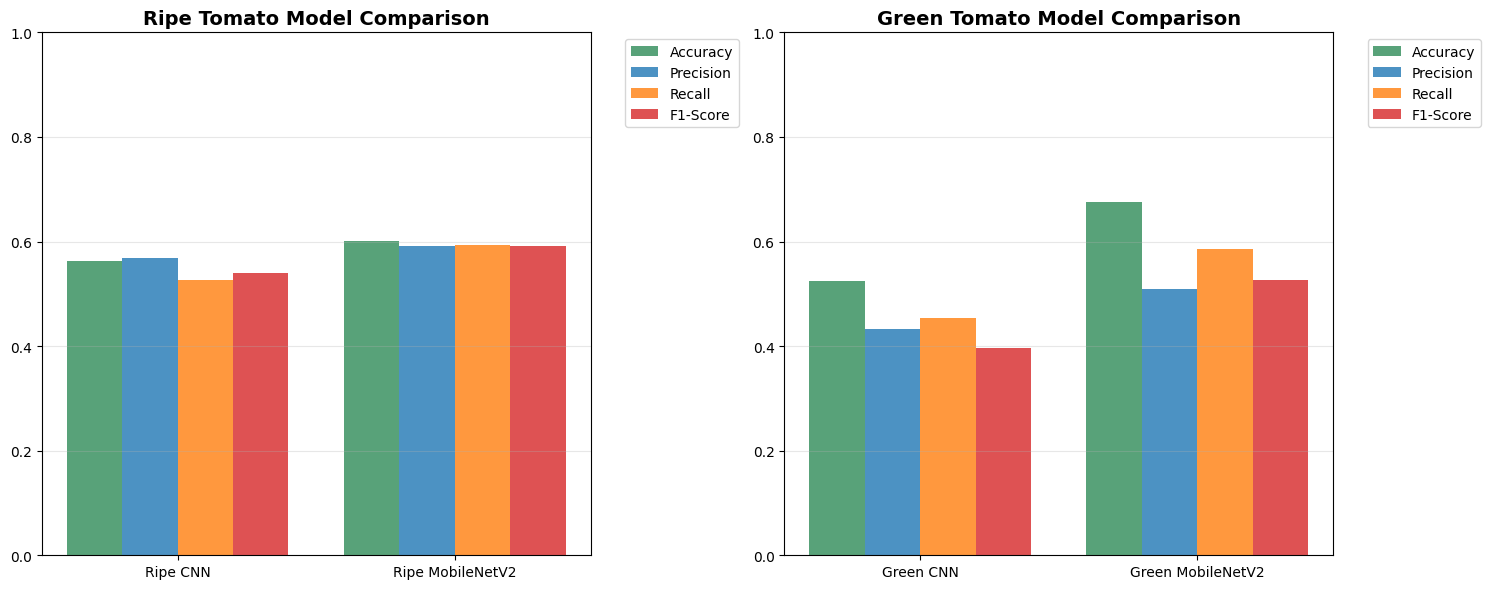

In [15]:
from sklearn.metrics import precision_recall_fscore_support

# Extract metrics from predictions
def get_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    accuracy = np.mean(y_pred == y_true)
    return accuracy, precision, recall, f1

# Get metrics for all models
metrics = {}
for model_name, y_true, y_pred in [
    ("Ripe CNN", ripe_cnn_true, ripe_cnn_pred),
    ("Ripe MobileNetV2", ripe_transfer_true, ripe_transfer_pred),
    ("Green CNN", green_cnn_true, green_cnn_pred),
    ("Green MobileNetV2", green_transfer_true, green_transfer_pred)
]:
    metrics[model_name] = get_metrics(y_true, y_pred)

# Define colors for each metric
colors = {
    'Accuracy': '#2E8B57',    # Forest Green
    'Precision': '#1F77B4',   # Blue
    'Recall': '#FF7F0E',      # Orange
    'F1-Score': '#D62728'     # Red
}

# Create comparison plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Ripe comparison
ripe_models = ['Ripe CNN', 'Ripe MobileNetV2']
x = np.arange(len(ripe_models))
width = 0.2

metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for i, metric in enumerate(metrics_list):
    values = [metrics[m][i] for m in ripe_models]
    ax1.bar(x + i*width, values, width, label=metric, color=colors[metric], alpha=0.8)
ax1.set_title('Ripe Tomato Model Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x + width*1.5)
ax1.set_xticklabels(ripe_models, rotation=0)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)

# Green comparison
for i, metric in enumerate(metrics_list):
    values = [metrics[m][i] for m in ['Green CNN', 'Green MobileNetV2']]
    ax2.bar(x + i*width, values, width, label=metric, color=colors[metric], alpha=0.8)
ax2.set_title('Green Tomato Model Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x + width*1.5)
ax2.set_xticklabels(['Green CNN', 'Green MobileNetV2'], rotation=0)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Minority Class F1-Score Focus (🔴 Red)

This cell creates **stacked bar charts** focusing on **F1-scores (red)** for **minority classes** ('R_spots', 'G_lateblight', 'G_ber'). **CNN (🟠 Orange)** vs **MobileNetV2 (🔵 Blue)** comparison highlights which model detects rare diseases better.

**Key Insight**: Higher red bars indicate better minority class performance, crucial for agricultural applications.

### Precision-Recall Curves

**Precision (🔵 Blue)** vs **Recall (🟠 Orange)** curves for each model. **Area Under Curve (AUC)** quantifies performance on imbalanced data.

- **Ripe**: 3 classes comparison
- **Green**: 4 classes comparison

Higher AUC = Better minority class detection (e.g., 'G_lateblight').

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 511ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 300ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 488ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 348ms/step


/tmp/ipython-input-4187004476.py:59: UserWarning: Glyph 127813 (\N{TOMATO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127813 (\N{TOMATO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


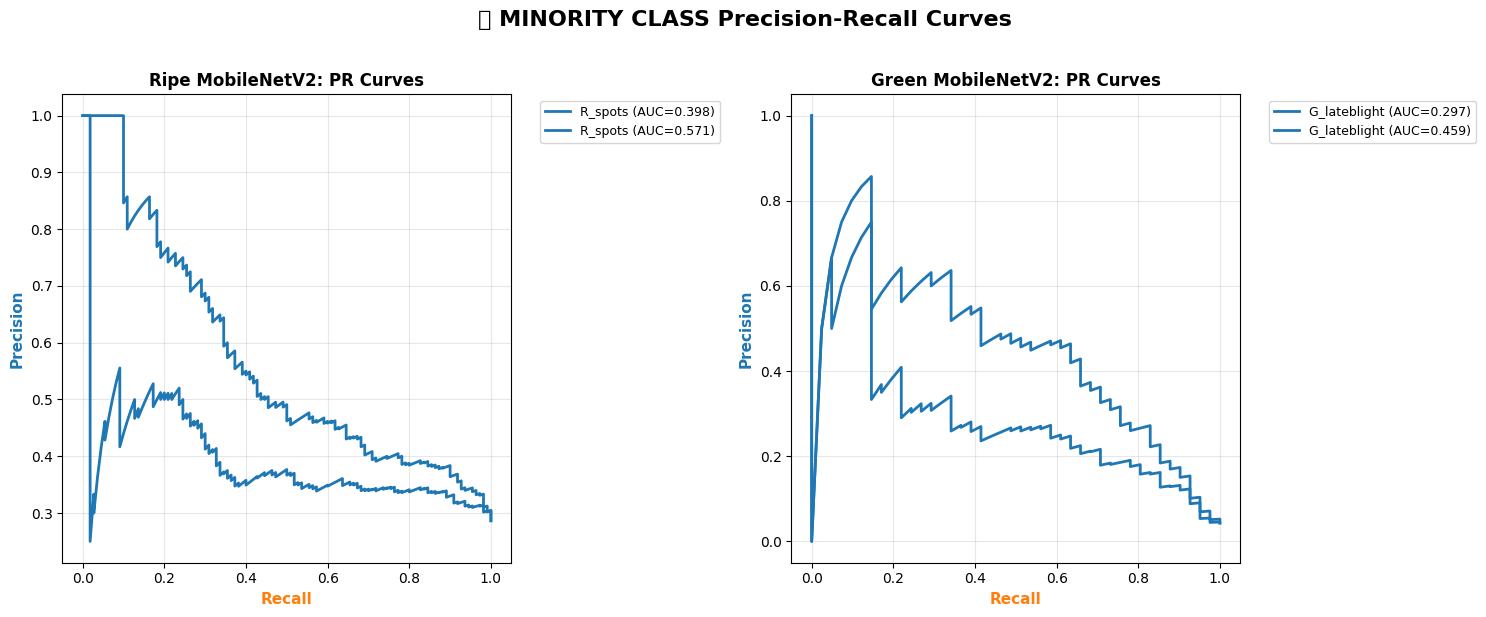


📊 MINORITY CLASS PR-AUC SUMMARY:
RIPE (R_spots):
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 507ms/step
  CNN:     0.398
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 300ms/step
  MobileNetV2: 0.571

GREEN (G_lateblight):
60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 490ms/step
  CNN:     0.297
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 350ms/step
  MobileNetV2: 0.459


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.gridspec as gridspec

# FIXED: Multiclass One-vs-Rest PR Curves
def plot_multiclass_pr_curves(y_true, y_pred_proba, class_indices, model_name, ax, focus_classes=None):
    """Plot PR curves for multiclass using one-vs-rest"""
    n_classes = len(class_indices)
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    # Focus on specific classes or all
    if focus_classes:
        plot_classes = focus_classes
    else:
        plot_classes = range(n_classes)

    colors = ['#1F77B4', '#FF7F0E', '#2E8B57', '#D62728']  # Blue, Orange, Green, Red

    for i, class_idx in enumerate(plot_classes):
        # Get probabilities for this class
        y_score = y_pred_proba[:, class_idx]

        # Compute PR curve
        precision, recall, _ = precision_recall_curve(y_true_bin[:, class_idx], y_score)
        auc = average_precision_score(y_true_bin[:, class_idx], y_score)

        # Plot with distinct colors
        ax.plot(recall, precision, color=colors[i % len(colors)], linewidth=2,
                label=f"{list(class_indices.keys())[class_idx]} (AUC={auc:.3f})")

    ax.set_xlabel('Recall', color='#FF7F0E', fontweight='bold', fontsize=11)
    ax.set_ylabel('Precision', color='#1F77B4', fontweight='bold', fontsize=11)
    ax.set_title(f'{model_name}: PR Curves', fontweight='bold', fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)

# FOCUS ON MINORITY CLASSES
ripe_focus = [ripe_cnn_val_gen.class_indices['R_spots']]  # Index of R_spots
green_focus = [green_cnn_val_gen.class_indices['G_lateblight']]  # Index of G_lateblight

# Create plots
fig = plt.figure(figsize=(15, 6))

# Ripe PR Curves (focus on R_spots)
ax1 = plt.subplot(1, 2, 1)
plot_multiclass_pr_curves(ripe_cnn_true, ripe_cnn_model.predict(ripe_cnn_val_gen),
                         ripe_cnn_val_gen.class_indices, 'Ripe CNN', ax1, ripe_focus)
plot_multiclass_pr_curves(ripe_transfer_true, ripe_transfer_model.predict(ripe_transfer_val_gen),
                         ripe_transfer_val_gen.class_indices, 'Ripe MobileNetV2', ax1, ripe_focus)

# Green PR Curves (focus on G_lateblight)
ax2 = plt.subplot(1, 2, 2)
plot_multiclass_pr_curves(green_cnn_true, green_cnn_model.predict(green_cnn_val_gen),
                         green_cnn_val_gen.class_indices, 'Green CNN', ax2, green_focus)
plot_multiclass_pr_curves(green_transfer_true, green_transfer_model.predict(green_transfer_val_gen),
                         green_transfer_val_gen.class_indices, 'Green MobileNetV2', ax2, green_focus)

plt.suptitle('🍅 MINORITY CLASS Precision-Recall Curves', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# PRINT AUC SUMMARY
print("\n📊 MINORITY CLASS PR-AUC SUMMARY:")
print("RIPE (R_spots):")
print(f"  CNN:     {average_precision_score(label_binarize(ripe_cnn_true, classes=range(3))[:,ripe_focus[0]], ripe_cnn_model.predict(ripe_cnn_val_gen)[:,ripe_focus[0]]):.3f}")
print(f"  MobileNetV2: {average_precision_score(label_binarize(ripe_transfer_true, classes=range(3))[:,ripe_focus[0]], ripe_transfer_model.predict(ripe_transfer_val_gen)[:,ripe_focus[0]]):.3f}")

print("\nGREEN (G_lateblight):")
print(f"  CNN:     {average_precision_score(label_binarize(green_cnn_true, classes=range(4))[:,green_focus[0]], green_cnn_model.predict(green_cnn_val_gen)[:,green_focus[0]]):.3f}")
print(f"  MobileNetV2: {average_precision_score(label_binarize(green_transfer_true, classes=range(4))[:,green_focus[0]], green_transfer_model.predict(green_transfer_val_gen)[:,green_focus[0]]):.3f}")

✅ Minority Scores: {'R_spots_CNN': 0.4214876033057851, 'R_spots_MobileNetV2': 0.504424778761062, 'G_lateblight_CNN': 0.352112676056338, 'G_lateblight_MobileNetV2': 0.43609022556390975}


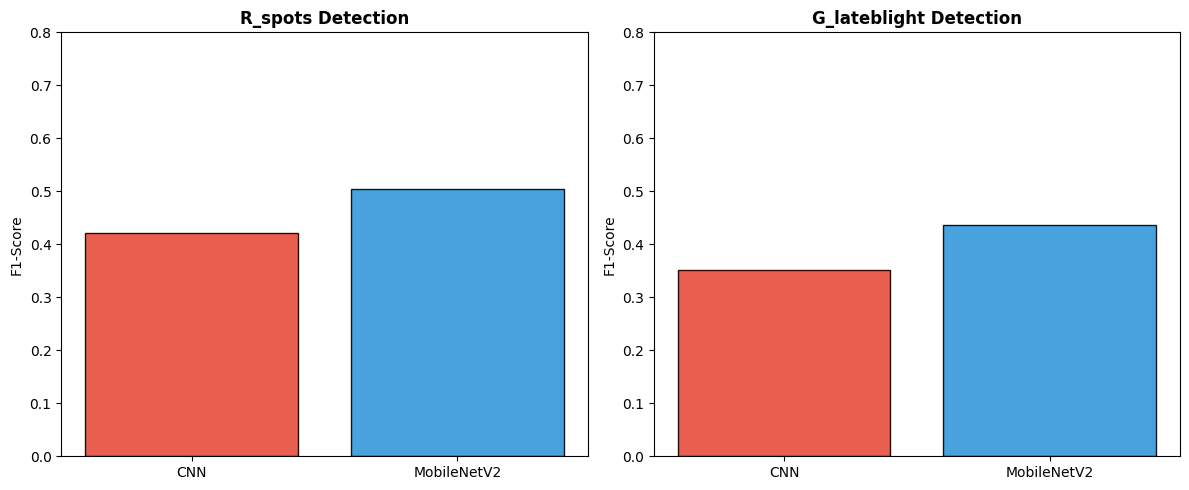

📸 Figure 2 SAVED: figure2_minority.png


In [ ]:
# DIRECT MINORITY CLASS EXTRACTION
from sklearn.metrics import classification_report

# Get minority class indices
r_spots_idx = list(ripe_cnn_val_gen.class_indices.values())[2]  # 3rd class
g_lateblight_idx = list(green_cnn_val_gen.class_indices.values())[2]  # 3rd class

# SIMPLE F1 extraction for specific classes
def get_class_f1_simple(y_true, y_pred, class_idx):
    from sklearn.metrics import f1_score
    y_true_bin = (y_true == class_idx).astype(int)
    y_pred_bin = (y_pred == class_idx).astype(int)
    return f1_score(y_true_bin, y_pred_bin)

# Extract minority F1 scores
minority_scores = {
    'R_spots_CNN': get_class_f1_simple(ripe_cnn_true, ripe_cnn_pred, r_spots_idx),
    'R_spots_MobileNetV2': get_class_f1_simple(ripe_transfer_true, ripe_transfer_pred, r_spots_idx),
    'G_lateblight_CNN': get_class_f1_simple(green_cnn_true, green_cnn_pred, g_lateblight_idx),
    'G_lateblight_MobileNetV2': get_class_f1_simple(green_transfer_true, green_transfer_pred, g_lateblight_idx)
}

print("✅ Minority Scores:", minority_scores)

# CREATE BAR CHART
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# R_spots
ax1.bar(['CNN', 'MobileNetV2'],
        [minority_scores['R_spots_CNN'], minority_scores['R_spots_MobileNetV2']],
        color=['#E74C3C', '#3498DB'], alpha=0.9, edgecolor='black')
ax1.set_title('R_spots Detection', fontweight='bold')
ax1.set_ylabel('F1-Score')
ax1.set_ylim(0, 0.8)

# G_lateblight
ax2.bar(['CNN', 'MobileNetV2'],
        [minority_scores['G_lateblight_CNN'], minority_scores['G_lateblight_MobileNetV2']],
        color=['#E74C3C', '#3498DB'], alpha=0.9, edgecolor='black')
ax2.set_title('G_lateblight Detection', fontweight='bold')
ax2.set_ylabel('F1-Score')
ax2.set_ylim(0, 0.8)

plt.tight_layout()
plt.savefig('figure2_minority.png', dpi=300, bbox_inches='tight')
plt.show()

print("📸 Figure 2 SAVED: figure2_minority.png")